# Modeling and simulation of an autonomous vehicle storage and retrieval system in $\chi Py$.

This is a Jupyter Notebook that simulates a "Modeling and simulation of an autonomous vehicle storage and retrieval system" in $\chi Py$. It is the intermediate assignment of the third year course Analysis of Production Systems of the BSc Mechanical Engineering at the Eindhoven University of Technology. It is used to test the capabilities of the written $\chi Py$ Python package as alternative to $\chi3$.

It is important to note that $\chi Py$ works fundamentally slighty different than $\chi3$ does. For example, buffers are always linked to a workstation/process of some sort. Modelling a single buffer only is therefor not possible in $\chi Py$, but is something asked in the assignment (since it works step by step). While modeling, it is still useful to model according to the steps used in the assignment. Because of this, this notebook is split into separate parts (denoted with a header) corresponding part of the assignment. This way each "phase"of modeling the system can still be seen.

Finally, each new part starts with a `%reset -f` line, removing all variables and imports to avoid conflicts with previous modeling parts. This also means that **each part can be executed separately**.


## Part 1 and 2 | Generator and Demand Buffer

In [1]:
%reset -f

### Imports
Imports Required Packages

In [2]:
import sys
#!{sys.executable} -m pip install simpy
#import simpy 
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp

### Model Variables

In [3]:
arrive: float = 70                                          # Rate of arrival
depth: int = 55                                             # The number of columns
number_of_orders: int = 10000                               # Number of orders to process        
totes: list = []                                            # List of processed orders
inf = float("inf")                                          # Infinity
env = cp.environment()                                      # Initiate Environment 

### Workstations

In [4]:
workstations = {
            "Vehicle": cp.Station(env = env, te = lambda: 0, delta = (arrive))
    }

### Run Environment (`runenv`)


In [5]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
def runenv(env, tote, workstations):
    arr = env.now
    t_arr.append([tote[0], arr])
    
    yield env.process(workstations["Vehicle"].proc(tote))  
    
    end = env.now
    t_exit.append([tote[0], end])
    totes.append(tote)

### Generator
(Note: $\chi Py$ works by default with the term `lots` for an item going through a system.)

To add column data to each individual tote, the `chipy.Generator` class has to be inherited in a new class, that simply adds another piece of data to the lot tuple. 

Look inside the source code for more details. Content shown here is copied form there and slightly altered to match the case. Since the entire assignment never tests machine failure, the fail initiation loop is left out the newly defined `gen` method.


In [6]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
    def gen(self, env, method = "Time", lots_max = None) -> None:
        if (method == "Time"):
            cond = lambda: 1
        elif (method == "n-processed"):
            cond = lambda: (len(self.lots) < lots_max)
        elif (method == "n-generated"):
            cond = lambda: (lot_ID < lots_max)
        lot_ID: int = 0  
        while (cond()):
            lot = (lot_ID, self.priority(), self.column())
            self.env.process(self.runenv(env, lot, self.stations))             
            yield env.timeout(self.ta())
            lot_ID += 1

In [7]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = workstations, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth)         #See https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html#numpy.random.randint
)

### Simulation


In [8]:
cp.simulate(env = env ,
            generator = G,
            method = "n-generated",
            lots_max = number_of_orders)

### Output
(Note: $\chi Py$ works by default with the term `lots` for an item going through a system.)

All Data Tables are disabled, since these tables have a `number_of_orders` amount of rows.

In [9]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = False)


SIMULATION SUMMARY

The average flow time equals 0.0
The standard deviation of the flow time equals 0.0
The variability of the flow time equals nan
The amount of products that passed through the run environment is 10000 in 702968.5803835165 time units



C:\Users\20181805\Documents\ChiPy\AOPS Assignment - V2\chipy\functions\prints\stats.py:86: RuntimeWarning: invalid value encountered in double_scalars
  print(f'The variability of the flow time equals {np.std(phi)/np.nanmean(phi)}')


## Part 3 | Vehicle as machine

In [10]:
%reset -f

### Imports

In [11]:
import sys
#!{sys.executable} -m pip install simpy
#import simpy 
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp

### Model Variables

In [12]:
arrive: float = 70                                          # Rate of arrival
depth: int = 55                                             # The number of columns
number_of_orders: int = 10000                               # Number of orders to process        
totes: list = []                                            # List of processed orders
inf = float("inf")                                          # Infinity
env = cp.environment()                                      # Initiate Environment 

### Workstations
Now the Vehicle will be modeled as a machine. This means a `te` value will now be assigned according to the assignment. This is a determinsitic time of `40`.

In [13]:
workstations = {
            "Vehicle": cp.Station(env = env, te = lambda: 40, delta = (arrive))
    }

### Run Environment (`runenv`)

In [14]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
def runenv(env, tote, workstations):
    arr = env.now
    t_arr.append([tote[0], arr])
    yield env.process(workstations["Vehicle"].proc(tote))  
    end = env.now
    t_exit.append([tote[0], end])
    totes.append(tote)

### Generator

In [15]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
    def gen(self, env, method = "Time", lots_max = None) -> None:
        if (method == "Time"):
            cond = lambda: 1
        elif (method == "n-processed"):
            cond = lambda: (len(self.lots) < lots_max)
        elif (method == "n-generated"):
            cond = lambda: (lot_ID < lots_max)
        lot_ID: int = 0  
        while (cond()):
            lot = (lot_ID, self.priority(), self.column())
            self.env.process(self.runenv(env, lot, self.stations))             
            yield env.timeout(self.ta())
            lot_ID += 1

In [16]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = workstations, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth)         #See https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html#numpy.random.randint
)

### Simulation

In [17]:
cp.simulate(env = env ,
            generator = G,
            method = "n-generated",
            lots_max = number_of_orders)

### Output

In [18]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = False)


SIMULATION SUMMARY

The average flow time equals 67.24724098339088
The standard deviation of the flow time equals 38.041717611862
The variability of the flow time equals 0.5656993068497452
The amount of products that passed through the run environment is 10000 in 703825.1705427187 time units



## Part 4 |  Vehicle accurately modeled

In [19]:
%reset -f

### Imports

In [20]:
import sys
#!{sys.executable} -m pip install simpy
#import simpy 
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp
from math import sqrt

### Model Variables

In [21]:
arrive: float = 70                           # Rate of arrival
depth: int = 55                              # The number of columns
number_of_orders: int = 10000                # Number of orders to process
lv: float = 3.0                              # Time to load/unload the vehicle
dv: float = 0.5                              # Unit width clearance 
vmaxv: float = 1.5                           # Maximum velocity of the vehicle
av: float = 1.0                              # Acceleration/deceleration of the vehicle
totes: list = []                             # List of processed orders
inf = float("inf")                           # Infinity
env = cp.environment()                       # Initiate Environment  

### Workstations
Since the process time `te` of a tote is now dependent on its column number, parsing the value trough at its initiation is not suitable for this case. Luckily, $\chi Py$ supports lot-specifc process times out of the box. The process time can be left undetermined at initiation, but needs to be passed to thr station once a lot enters, which is done in the `runenv`.

In [22]:
workstations = {
            "Vehicle": cp.Station(env = env, delta = (arrive))
    }

### Run Environment (`runenv`)

In [23]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
def runenv(env, tote, workstations):
    arr = env.now
    t_arr.append([tote[0], arr])
#----------------------------------------------------------
# VEHICLE
#----------------------------------------------------------
    dmin = (vmaxv**(2))/(av)
    d = tote[2]*dv
    if (d <= dmin):
        t_travel = sqrt((4*d)/(av))
    elif (d > dmin):
        t_travel = (d-dmin)/(vmaxv) + (2*vmaxv)/(av)
    te = 2*(t_travel + lv)
    
    yield env.process(workstations["Vehicle"].proc(lot=tote,te=lambda: te))  
    end = env.now
    t_exit.append([tote[0], end])
    totes.append(tote)

### Generator

In [24]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
    def gen(self, env, method = "Time", lots_max = None) -> None:
        if (method == "Time"):
            cond = lambda: 1
        elif (method == "n-processed"):
            cond = lambda: (len(self.lots) < lots_max)
        elif (method == "n-generated"):
            cond = lambda: (lot_ID < lots_max)
        lot_ID: int = 0  
        while (cond()):
            lot = (lot_ID, self.priority(), self.column())
            self.env.process(self.runenv(env, lot, self.stations))             
            yield env.timeout(self.ta())
            lot_ID += 1

In [25]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = workstations, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth)         #See https://numpy.org/doc/stable/reference/random/generated/numpy.random.randint.html#numpy.random.randint
)

### Simulation

In [26]:
cp.simulate(env = env ,
            generator = G,
            method = "n-generated",
            lots_max = number_of_orders)

### Output

In [27]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = False)


SIMULATION SUMMARY

The average flow time equals 38.17907824305325
The standard deviation of the flow time equals 20.861513117667798
The variability of the flow time equals 0.5464121733076044
The amount of products that passed through the run environment is 10000 in 703804.3681310746 time units



## Part 5 + 6 |  Lift as two stage machine with single tier buffer

* For **PART 5**: `bc = inf`
* For **PART 6**: `bc = 1`

In [28]:
%reset -f

### Imports

In [29]:
import sys
#!{sys.executable} -m pip install simpy
#import simpy 
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp
from math import sqrt

### Model Variables

In [30]:
inf = float("inf")                           # Infinity
arrive: float = 70                           # Rate of arrival
depth: int = 55                              # The number of columns
lv: float = 3.0                              # Time to load/unload the vehicle
dv: float = 0.5                              # Unit width clearance 
vmaxv: float = 1.5                           # Maximum velocity of the vehicle
av: float = 1.0                              # Acceleration/deceleration of the vehicle
ll: float = 2.0                              # Time to load/unload the lift
tl: float = 23.0                             # Time to move the lift to its destination
bc: int = 1                                  # Buffer capacity
totes: list = []                             # List of processed orders
env = cp.environment()                       # Initiate Environment 

### Workstations
The way of modelling the lift is slightly different compared to the $\chi3$ way. Since $\chi Py$ works with the concept of resource occupation (and $\chi3$ mainly with channels) we will model the lift with an `te` of `2(ll+tl)`. This way, the part of "informing the lift to go to tier x" already counts as resource occupation, since a single tote specifically requests the list pick it up.

In [31]:
workstations = {
            "Vehicle": cp.Station(env = env, te = lambda: 0, delta = (arrive)),
            "Lift": cp.Station(env = env, te = lambda: 2*(ll + tl), delta = (arrive), queuesize = bc)
    }

### Run Environment (`runenv`)
To make finite buffers work properly (a generator cannot hold products), the vehicle with process time zero is put inbetween, that has a proper release hold control action when the upcoming buffer is full. 

In [32]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
    
def runenv(env, tote, workstations):
    arr = env.now
    t_arr.append([tote[0], arr])
    
#----------------------------------------------------------
# VEHICLE (NOTE: NOT MODELLED IN THIS PART!)
#----------------------------------------------------------
    
    yield env.process(workstations["Vehicle"].proc(lot=tote,us=workstations["Lift"])) 
    
#----------------------------------------------------------
# LIFT
#----------------------------------------------------------
    
    print("Generator: Tote %s Informed Lift to go to tier %s at time %s" % (tote[0],tote[2], env.now))
    yield env.process(workstations["Lift"].proc(tote))  
    print("Exit: Tote %s has completely left the Lift and has been received by the Exit at time %s" % (tote[0], env.now));
    
    end = env.now
    t_exit.append([tote[0], end])
    totes.append(tote)


### Generator
In this part, the generator works quite a bit different compared to the other cases. See the assignment template `chi` code. Note that the Lift has to travel to pickup the tote first, then travels back to drop the tote at the desired location. Then it waits till the new tote arrives and moves back to pick it up. Since we will eventually need columns, they are still left in the generator, in contrast to the `chi` template shown in the assignment.

Note that the case here is modelled slightly different. Where the $\chi3$ model starts the delay once the lift has completed its process, the delay in the case of the `ToteGenerator` is done per tote generation, like a rate of arrival. If one wants to wait till the lift has completed its process, the `self.env.process(self.runenv(env, lot, self.stations))` statement has to be yielded. The output still seems to be a bit off in the favour of the $\chi Py$'s implementation: It properly does the second delay of the list (`10`) instead of a delay of zero (in the case of the $\chi3$ template). Note however, that using the provided delay list (that $\chi Py$ handles properly in comparison to $\chi 3$) the buffer capacity of the Lift buffer is never reached (since the process time of the lift is determisnistically 23). This can indeed be seen when running the simulation for both values of `bc` (`inf` and `1`) 

Also note that the second print the $\chi3$ tempate has is not present here. It can, however, be added by inheriting the `chipy.Station` `class` and rewriting the `run` method, splitting its timeout in 2 separate timeouts of `(ll + tl)` and to print the missing statment between the two timeouts.



In [33]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0, tier = lambda: 1):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
        self.tier = tier
        self.delays = [1.0, 10.0, 100.0, 100.0]
        
    def gen(self, env, lots_max = "NaN") -> None:
        lot_ID: int = 0
        while (len(self.delays) > 0): 
            yield env.timeout(self.delays[0])
            self.delays = self.delays[1:]
            lot = (lot_ID, self.column(), self.tier())
            self.env.process(self.runenv(env, lot, self.stations))             
            lot_ID += 1

In [34]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = workstations, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth+1),
            tier = lambda: 1
)

### Simulation
In this case, the simulation method does not fit any of the three methods the `cp.simulate` method allows, since the `ToteGenerator` is altered such to only handle the specific required case. Therefore, the environments `run` method has to be called manually.

In [35]:
event = env.process(G.gen(env))
env.run()

Generator: Tote 0 Informed Lift to go to tier 1 at time 1.0
Exit: Tote 0 has completely left the Lift and has been received by the Exit at time 51.0
Generator: Tote 1 Informed Lift to go to tier 1 at time 51.0
Exit: Tote 1 has completely left the Lift and has been received by the Exit at time 101.0
Generator: Tote 2 Informed Lift to go to tier 1 at time 111.0
Exit: Tote 2 has completely left the Lift and has been received by the Exit at time 161.0
Generator: Tote 3 Informed Lift to go to tier 1 at time 211.0
Exit: Tote 3 has completely left the Lift and has been received by the Exit at time 261.0


### Output
Outputting is handled via `runenv` in this case. See the print of the Simulation section. As extra, to check finite buffer behaviour, the `stats` method will also be called below. Note that the second tote (ID = 1) has a larger flow time, since the lift still needs 40 time units to process the first tote (ID = 0). This is thus expected behaviour.

In [36]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = True)


SIMULATION SUMMARY

The average flow time equals 60.0
The standard deviation of the flow time equals 17.320508075688775
The variability of the flow time equals 0.2886751345948129
The amount of products that passed through the run environment is 4 in 261.0 time units

FLOW TIME PER LOT ID

 Lot ID  Flow Time  Entry Time
      0       50.0         1.0
      1       90.0        11.0
      2       50.0       111.0
      3       50.0       211.0

(This table is also saved as /data/phi_data.csv)



## Part 7 |  Buffer with multiple tiers
The figure below shows the model with tiers.

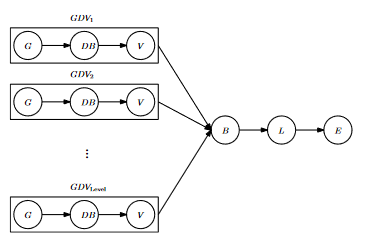

(Note: in Part 7, the vehicle is still left out!) 

Only 1 generator will (and can) be used, due to the nature of $\chi Py$. Each Tier will be modelled as a separate dictionary, all stored in a list. Since a `tote` is a tuple with a field that describes its tier, `runenv` can select the proper dict from the Tiers list to use. This also immediatly shows the power of the `runenv` method: as long as it is possible in Python, a lot (in this case tote) can take any path desirable!

The buffer will be modeled as a shared buffer with **total** capacity `bc`. Therefore this part is a bit different compared to its $\chi3$ counterpart. Due to the resource concept $\chi Py$ is build upon, a buffer (queue) is always linked to a station's process, and cannot be decoupled!  


In [37]:
%reset -f

### Imports

In [38]:
from math import sqrt
import sys
import simpy
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp

### Model Variables

In [39]:
inf = float("inf")                           # Infinity
arrive: float = 70                           # Rate of arrival
depth: int = 55                              # The number of columns
lv: float = 3.0                              # Time to load/unload the vehicle
dv: float = 0.5                              # Unit width clearance 
vmaxv: float = 1.5                           # Maximum velocity of the vehicle
av: float = 1.0                              # Acceleration/deceleration of the vehicle
ll: float = 2.0                              # Time to load/unload the lift
tl: float = 23.0                             # Time to move the lift to its destination
bc: int = 1                                  # Buffer capacity
Level: int = 2                               # The number of tiers
totes: list = []                             # List of processed orders
env = cp.environment()                       # Initiate Environment 

### Workstations
First, a "shared" lift will be initiated. Next, a single tier is formed using a `dict` (like the general workstation dictionaries). This dictionary will be re-initiated `Level` times. Since the Lift is defined before this loop, its Generator Object ID will be the same in each Tier. In essence, the lift is therefore shared over all tiers.

In contrast to the assigment, the Vehicle will already be implemented in the tiers. Its bufferlength is `inf` and `te = 0`. The reason why it is still already implemented is to test of the concept of sending totes in the desired tiers actually works. 

The last three prints are to check if each tier is initiated properly. Note that the lift obejct is identical in both tiers!

In [40]:
Lift = cp.Station(env = env, te = lambda: 2*(ll + tl), delta = (arrive), queuesize = bc)
Tiers = []

for j in range(0,Level,1):
    Tiers.append({
        "Vehicle": cp.Station(env = env, te = lambda: 0, delta = (arrive)),
        "Lift": Lift
    })
print(len(Tiers))
print(Tiers[0])
print(Tiers[1])

2
{'Vehicle': <chipy.processes.station.Station object at 0x000001D25E1E4130>, 'Lift': <chipy.processes.station.Station object at 0x000001D25E1E4100>}
{'Vehicle': <chipy.processes.station.Station object at 0x000001D25E1E4250>, 'Lift': <chipy.processes.station.Station object at 0x000001D25E1E4100>}


### Run Environment (`runenv`)


In [41]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
    
def runenv(env, tote, Tiers):
    arr = env.now
    t_arr.append([tote[0], arr])
    
    tier = tote[2] - 1
    
#----------------------------------------------------------
# VEHICLE 
#----------------------------------------------------------
    
    yield env.process(Tiers[tier]["Vehicle"].proc(tote, Tiers[tier]["Lift"]))
    
#----------------------------------------------------------
# LIFT
#----------------------------------------------------------
    
    print("Generator: Tote %s Informed Lift to go to tier %s at time %s" % (tote[0],tote[2], env.now))
    yield env.process(Tiers[tier]["Lift"].proc(tote))  
    print("Exit: Tote %s has completely left the Lift and has been received by the Exit at time %s" % (tote[0], env.now));
    
    end = env.now
    t_exit.append([tote[0], end])
    totes.append(tote)

### Generator
Note that the behaviour of this generator is slightly different than the $\chi3$ equivalent! Where the $\chi3$ version generates 2 products per tier `1` time unit apart, this version takes the delays as usual and randomly generates a corresponding lot tier. For a similar approach to the $\chi3$ variant, take a look at the generator of exersice 9. The way it handles per tier generation can be used here as well. The `1` time unit delay per tier generation can be added as a `env.timeout(1)` within the nested tier generation loop.  

In Part 8, it is chosen to model the generator exactly as in the $\chi3$ equivalent! In this exersice it has however been left as is, to model/test different generation methods and check if $\chi Py$ gives expected results in both cases!

In [42]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0, tier = lambda: 1):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
        self.tier = tier
        self.delays = [1.0, 10.0, 100.0, 100.0]
        
    def gen(self, env, lots_max = "NaN") -> None:
        lot_ID: int = 0
        while (len(self.delays) > 0):
            yield env.timeout(self.delays[0])
            self.delays = self.delays[1:]
            lot = (lot_ID, self.column(), self.tier())
            self.env.process(self.runenv(env, lot, self.stations))             
            lot_ID += 1

In [43]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = Tiers, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth+1),
            tier = lambda: rd.randint(1, Level)
)

### Simulation

In [44]:
event = env.process(G.gen(env))
env.run()

Generator: Tote 0 Informed Lift to go to tier 1 at time 1.0
Exit: Tote 0 has completely left the Lift and has been received by the Exit at time 51.0
Generator: Tote 1 Informed Lift to go to tier 2 at time 51.0
Exit: Tote 1 has completely left the Lift and has been received by the Exit at time 101.0
Generator: Tote 2 Informed Lift to go to tier 1 at time 111.0
Exit: Tote 2 has completely left the Lift and has been received by the Exit at time 161.0
Generator: Tote 3 Informed Lift to go to tier 2 at time 211.0
Exit: Tote 3 has completely left the Lift and has been received by the Exit at time 261.0


### Output
Outputting is handled via `runenv` in this case. See the print of the Simulation section. As extra, The `stats` method will also be called below. Note that due to the chosen generation method, the output is the same as in Exersice 6.

In [45]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = True)


SIMULATION SUMMARY

The average flow time equals 60.0
The standard deviation of the flow time equals 17.320508075688775
The variability of the flow time equals 0.2886751345948129
The amount of products that passed through the run environment is 4 in 261.0 time units

FLOW TIME PER LOT ID

 Lot ID  Flow Time  Entry Time
      0       50.0         1.0
      1       90.0        11.0
      2       50.0       111.0
      3       50.0       211.0

(This table is also saved as /data/phi_data.csv)



## Part 8 |   Lift accurately modelled
This is essentially the same as Part 7, but just like with the `Vehicle`, now `te` will be calculated (based on its velocity and acceleration profile) beforehand to model the lift accuratly. 

In [46]:
%reset -f

### Imports

In [47]:
from math import sqrt
import sys
import simpy
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp

### Model Variables

In [48]:
inf = float("inf")                           # Infinity
arrive: float = 70                           # Rate of arrival
depth: int = 55                              # The number of columns
lv: float = 3.0                              # Time to load/unload the vehicle
dv: float = 0.5                              # Unit width clearance 
vmaxv: float = 1.5                           # Maximum velocity of the vehicle
av: float = 1.0                              # Acceleration/deceleration of the vehicle
ll: float = 2.0                              # Time to load/unload the lift
al: float = 7.0                              # Acceleration/deceleration of lift
dl: float = 0.8                              # Unit height clearance
vmaxl: float = 5.0                           # Maximum velocity of lift     
bc: int = 1                                  # Buffer capacity
Level: int = 2                               # The number of tiers
totes: list = []                             # List of processed orders
env = cp.environment()                       # Initiate Environment 

### Workstations
Note that in this part, the Vehicle is still not modelled. This will be done in Part 9, where all simulation bits are put together.

In [49]:
Lift = cp.Station(env = env, delta = (arrive))
Tiers = []

for j in range(0,Level,1):
    Tiers.append({
        "Vehicle": cp.Station(env = env, te = lambda: 0, delta = (arrive)),
        "Lift": Lift
    })

### Run Environment (`runenv`)


In [50]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
    
def runenv(env, tote, Tiers):
    arr = env.now
    t_arr.append([tote[0], arr])
    
    tier = tote[2] - 1
    
#----------------------------------------------------------
# VEHICLE 
#----------------------------------------------------------
    
    yield env.process(Tiers[tier]["Vehicle"].proc(tote, Tiers[tier]["Lift"]))
    
#----------------------------------------------------------
# LIFT
#----------------------------------------------------------
    
    dminl = (vmaxl**2)/(al)
    d_lift = (tote[2])*dl
    if (d_lift <= dminl):
        t_travel_lift = sqrt(4*d_lift/al)
    elif (d_lift > dminl):
        t_travel_lift = (d_lift-dminl)/vmaxl + (2*vmaxl)/al
    te_lift = 2*(ll + t_travel_lift)
    
    print("Generator: Tote %s Informed Lift to go to tier %s at time %s" % (tote[0],tote[2], env.now))
    yield env.process(Tiers[tier]["Lift"].proc(lot = tote,te = lambda: te_lift))  
    print("Exit: Tote %s has completely left the Lift and has been received by the Exit at time %s" % (tote[0], env.now));
    
    end = env.now
    t_exit.append([tote[0], end])
    totes.append(tote)

### Generator
Note that the behaviour of this generator is different compared to exersice 7, and now corresponds better with the generator of the $\chi Py$ equivalent! Also the results are (obviously) the same, meaning that the tiers to their work properly!

In [51]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0, tier = lambda: 1):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
        self.tier = tier
        self.delays = [10.0, 100.0, 100.0, 100.0]
        
    def gen(self, env, lots_max = "NaN") -> None:
        lot_ID: int = 0
        while (len(self.delays) > 0):
            lot = (lot_ID, self.column(), self.tier[0])
            self.env.process(self.runenv(env, lot, self.stations))
            yield env.timeout(1)
            lot_ID += 1
            lot = (lot_ID, self.column(), self.tier[1])
            self.env.process(self.runenv(env, lot, self.stations))
            lot_ID += 1
            yield env.timeout(self.delays[0]-1)
            self.delays = self.delays[1:]

In [52]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = Tiers, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth+1),
            tier = range(1, Level+1, 1)
)

### Simulation

In [53]:
event = env.process(G.gen(env))
env.run()

Generator: Tote 0 Informed Lift to go to tier 1 at time 0
Generator: Tote 1 Informed Lift to go to tier 2 at time 1
Exit: Tote 0 has completely left the Lift and has been received by the Exit at time 5.352246807565627
Generator: Tote 2 Informed Lift to go to tier 1 at time 10.0
Generator: Tote 3 Informed Lift to go to tier 2 at time 11.0
Exit: Tote 1 has completely left the Lift and has been received by the Exit at time 11.264612582500657
Exit: Tote 3 has completely left the Lift and has been received by the Exit at time 17.176978357435686
Exit: Tote 2 has completely left the Lift and has been received by the Exit at time 22.529225165001314
Generator: Tote 4 Informed Lift to go to tier 1 at time 110.0
Generator: Tote 5 Informed Lift to go to tier 2 at time 111.0
Exit: Tote 4 has completely left the Lift and has been received by the Exit at time 115.35224680756562
Exit: Tote 5 has completely left the Lift and has been received by the Exit at time 121.26461258250065
Generator: Tote 6 Inf

### Output
Outputting is handled via `runenv` in this case. See the print of the Simulation section. As extra, The `stats` method will also be called below. Note that due to the chosen generation method, the output is the same as in Exersice 6. Again, look at exersice 9's generator to model it like the $\chi3$ equivalent.

In [54]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = True)


SIMULATION SUMMARY

The average flow time equals 8.19459771157948
The standard deviation of the flow time equals 2.7375067054786246
The variability of the flow time equals 0.334062366674859
The amount of products that passed through the run environment is 8 in 221.26461258250066 time units

FLOW TIME PER LOT ID

 Lot ID  Flow Time  Entry Time
      0   5.352247         0.0
      1  10.264613         1.0
      3   6.176978        11.0
      2  12.529225        10.0
      4   5.352247       110.0
      5  10.264613       111.0
      6   5.352247       210.0
      7  10.264613       211.0

(This table is also saved as /data/phi_data.csv)



## Part 9 | Entire system
In this final part, the entire system will be modelled with a "normal" `ta` (instead of the delay list). Since we work with a single Generator (since $\chi Py$ only works with one), it has to be altered to generate totes at the correct rate for the correct Tier. This is done by extending the `chipy.Generator.gen` method.  

In [55]:
%reset -f

### Imports

In [56]:
from math import sqrt
import sys
import simpy
import numpy as np
import pandas as pd
import random as rd
import os
import sys
import matplotlib.pyplot as plt
import chipy as cp
import time

### Model Variables

In [57]:
inf = float("inf")                           # Infinity 
lv: float = 3.0                              # Time to load/unload the vehicle
dv: float = 0.5                              # Unit width clearance 
vmaxv: float = 1.5                           # Maximum velocity of the vehicle
av: float = 1.0                              # Acceleration/deceleration of the vehicle
ll: float = 2.0                              # Time to load/unload the lift
dl: float = 0.8                              # Unit height clearance
vmaxl: float = 5.0                           # Maximum velocity of lift
al: float = 7.0                              # Acceleration/deceleration of lift
bc: int = inf                                # Buffer capacity
arrive: float = 70                           # Rate of arrival
Level: int = 9                               # The number of tiers
depth: int = 55                              # The number of columns
number_of_orders: int = 1*10**(4)            # Number of orders to process
Tiers: list = []                             # List of individual tiers
totes: list = []                             # List of processed orders
env = cp.environment()                       # Initiate Environment

### Workstations
Note that the througput $\delta$ of the `Vehicle` is the total rate of arrival divided by the amount of (parallel) tiers.

In [58]:
Lift = cp.Station(env = env, delta = (arrive), queuesize = bc)

for j in np.arange(0,Level,1):
    Tiers.append({
        "Vehicle": cp.Station(env = env, delta = (arrive/Level)),
        "Lift": Lift
    })
print(len(Tiers))
print(Tiers[0])
print(Tiers[1])

9
{'Vehicle': <chipy.processes.station.Station object at 0x000001D25E1F85E0>, 'Lift': <chipy.processes.station.Station object at 0x000001D25E1F8250>}
{'Vehicle': <chipy.processes.station.Station object at 0x000001D25E1F8A60>, 'Lift': <chipy.processes.station.Station object at 0x000001D25E1F8250>}


### Run Environment (`runenv`)


In [59]:
t_arr: list = []     # Arrive times of totes
t_exit: list = []    # Exit times of totes
phi: list = []       # Phi list to calculate average flowtime per lot, like in chi 
    
def runenv(env, tote, Tiers):
    arr = env.now
    t_arr.append([tote[0], arr])
    
    tier = tote[2] - 1
    # NOTE Dictionary Indexing starts at zero!
    
#----------------------------------------------------------
# VEHICLE 
#----------------------------------------------------------
    
    dminv = (vmaxv**(2))/(av)
    d_vehicle = tote[1]*dv
    
    if (d_vehicle <= dminv):
        t_travel_vehicle = sqrt((4*d_vehicle)/(av))
    elif (d_vehicle > dminv):
        t_travel_vehicle = (d_vehicle-dminv)/(vmaxv) + (2*vmaxv)/(av)
    
    te_vehicle = 2*(t_travel_vehicle + lv)
    yield env.process(Tiers[tier]["Vehicle"].proc(lot = tote,te = lambda: te_vehicle,us = Tiers[tier]["Lift"]))
    
#----------------------------------------------------------
# LIFT
#----------------------------------------------------------
    
    dminl = (vmaxl**2)/(al)
    d_lift = (tote[2])*dl 
    # NOTE d = dl(i+1), i \in {0,Level-1}. tote[2] = Level
    if (d_lift <= dminl):
        t_travel_lift = sqrt(4*d_lift/al)
    elif (d_lift > dminl):
        t_travel_lift = (d_lift-dminl)/vmaxl + (2*vmaxl)/al
    te_lift = 2*(ll + t_travel_lift)
    yield env.process(Tiers[tier]["Lift"].proc(lot = tote,te = lambda: te_lift))  
    
    end = env.now
    t_exit.append([tote[0], end])
    phi.append(end-arr)
    totes.append(tote)

### Generator

In [60]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0, tier = lambda: 1):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
        self.level = tier
        self.levels = range(1,self.level+1,1) 
    def gen(self, env, method = "Time", lots_max = None) -> None:
        if (method == "Time"):
            cond = lambda: 1
        elif (method == "n-processed"):
            cond = lambda: (len(self.lots) < lots_max)
        elif (method == "n-generated"):
            cond = lambda: (lot_ID < lots_max)
        j: int = 0
        lot_ID: int = 0
        while (cond()):
            yield env.timeout(self.ta())
            lot = (lot_ID, self.column(), self.levels[j])
            self.env.process(self.runenv(env, lot, self.stations))
            lot_ID += 1
            j += 1
            if (j > (self.level-1)):
                j = 0

In [61]:
G = ToteGenerator(
            env = env,
            ta = lambda: rd.expovariate((arrive)**(-1)),   
            stations = Tiers, 
            runenv = runenv,
            lots = totes,
            column = lambda: rd.randint(1, depth),
            tier = Level
)

### Simulation


In [62]:
start_sim = time.time()
cp.simulate(env = env ,
            generator = G,
            method = "n-generated",
            lots_max = number_of_orders)
print(f"It took {time.time()-start_sim} [s] to perform the simulation")

It took 3.565502405166626 [s] to perform the simulation


### Summary Output

In [63]:
cp.stats(lots = totes, 
        t_start = t_arr,
        t_end = t_exit,
        sim_time = t_exit[-1][1],
        generate_table = False)


SIMULATION SUMMARY

The average flow time equals 34.969698714621906
The standard deviation of the flow time equals 10.78373141874099
The variability of the flow time equals 0.30837358670842596
The amount of products that passed through the run environment is 10000 in 691883.5892018371 time units



# ORG GEN

In [64]:
class ToteGenerator(cp.Generator):
    def __init__(self, env, ta, runenv, lots, stations, priority = lambda: 0, column = lambda: 0, tier = lambda: 1):
        super().__init__(env, ta, runenv, lots, stations, priority)
        self.column = column
        self.level = tier
        self.levels = range(1,self.level+1,1) 
    def gen(self, env, method = "Time", lots_max = None) -> None:
        if (method == "Time"):
            cond = lambda: 1
        elif (method == "n-processed"):
            cond = lambda: (len(self.lots) < lots_max)
        elif (method == "n-generated"):
            cond = lambda: (lot_ID < lots_max)
        j: int = 0
        lot_ID: int = 0
        while (cond()):
            yield env.timeout(self.ta())
            lot = (lot_ID, self.column(), self.levels[j])
            self.env.process(self.runenv(env, lot, self.stations))
            lot_ID += 1
            j += 1
            if (j > (self.level-1)):
                j = 0

# ALT GEN 2